In [ ]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
print("Loading Water_potability_data_glug_glug....")
df = pd.read_excel("../water_potability_scaled.xlsx", engine="openpyxl")
X = df.drop("Potability", axis=1).values
y = df["Potability"].values

print("Splitting For Training...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Splitting for validation...")
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Data is already scaled and class-balanced from clean_data.ipynb
print(f"Train class counts: {np.bincount(y_train.astype(int))}")
print(f"Val   class counts: {np.bincount(y_val.astype(int))}")
print(f"Test  class counts: {np.bincount(y_test.astype(int))}")


Loading Water_potability_data_glug_glug....
Splitting For Training...
Splitting for validation...

Before SMOTE — Train class counts: [7431 6510]
After  SMOTE — Train class counts: [7431 7431]
Training set size grew from original to 14862 samples


In [17]:
l2 = keras.regularizers.l2(0.001)

potability_model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation="relu", kernel_regularizer=l2),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu", kernel_regularizer=l2),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu", kernel_regularizer=l2),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])

potability_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=['accuracy', keras.metrics.AUC(name="auc")]
)

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_auc',
    patience=20,
    restore_best_weights=True,
    mode='max'
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=1e-6,
    verbose=1
)

print("\n Training Model ...")

good_potability = potability_model.fit(
    X_train, y_train,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\n Evaluating Model")
potability_model.evaluate(X_test, y_test)



 Training Model ...
Epoch 1/200
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7093 - auc: 0.7934 - loss: 0.6924 - val_accuracy: 0.7699 - val_auc: 0.8743 - val_loss: 0.5860 - learning_rate: 0.0010
Epoch 2/200
465/465 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7440 - auc: 0.8369 - loss: 0.6107 - val_accuracy: 0.7863 - val_auc: 0.8808 - val_loss: 0.5532 - learning_rate: 0.0010
Epoch 3/200
465/465 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7628 - auc: 0.8544 - loss: 0.5672 - val_accuracy: 0.7917 - val_auc: 0.8876 - val_loss: 0.5285 - learning_rate: 0.0010
Epoch 4/200
465/465 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7706 - auc: 0.8644 - loss: 0.5325 - val_accuracy: 0.7909 - val_auc: 0.8915 - val_loss: 0.5013 - learning_rate: 0.0010
Epoch 5/200
465/465 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7812 - auc: 0.8733 - loss: 0.5041 - val_accuracy: 0.8124 - val_auc: 0.8999 - val_loss: 0.4652 - learning_rate: 0.0010
Epoch 6/200
465/465 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

[0.30950674414634705, 0.888455331325531, 0.9614257216453552]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Optimal threshold (from val set): 0.4571
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step
Confusion Matrix:
 [[2163  160]
 [ 327 1707]]
              precision    recall  f1-score   support

 Not Potable       0.87      0.93      0.90      2323
     Potable       0.91      0.84      0.88      2034

    accuracy                           0.89      4357
   macro avg       0.89      0.89      0.89      4357
weighted avg       0.89      0.89      0.89      4357



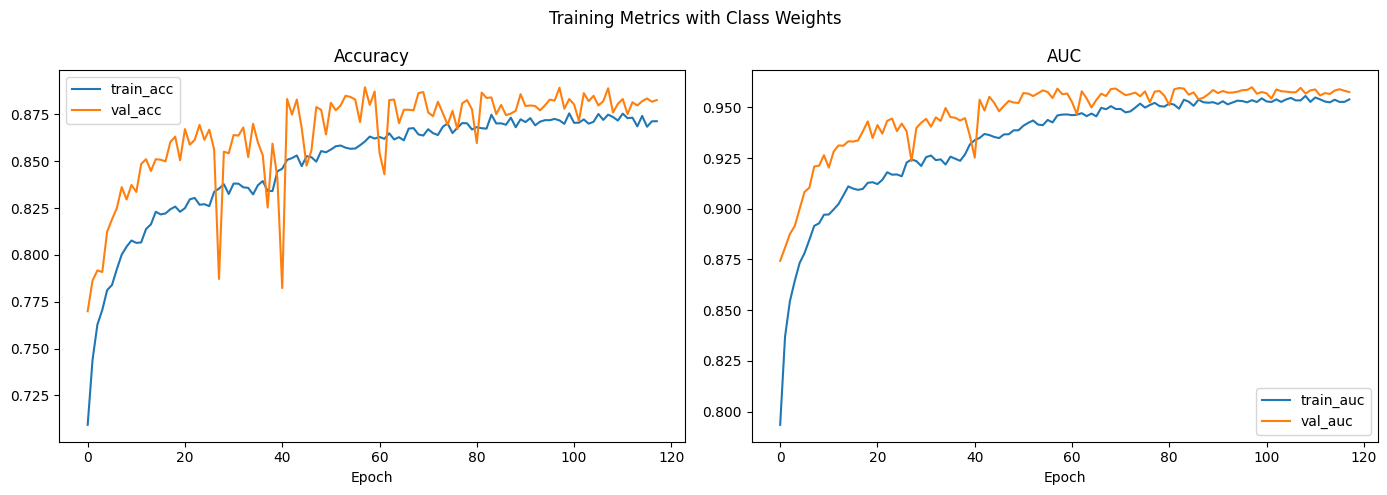

In [18]:
# Plot Training Metrics
def plot_loss(history):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy
    axes[0].plot(history.history['accuracy'], label='train_acc')
    axes[0].plot(history.history['val_accuracy'], label='val_acc')
    axes[0].set_title('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()

    # AUC
    axes[1].plot(history.history['auc'], label='train_auc')
    axes[1].plot(history.history['val_auc'], label='val_auc')
    axes[1].set_title('AUC')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()

    plt.suptitle('Training Metrics with Class Weights')
    plt.tight_layout()
    plt.show()

# --- Find optimal threshold from validation set ---
from sklearn.metrics import roc_curve

val_probs = potability_model.predict(X_val).ravel()
fpr, tpr, thresholds = roc_curve(y_val, val_probs)
# Pick threshold that maximizes (TPR - FPR), i.e. Youden's J
best_idx = np.argmax(tpr - fpr)
best_threshold = thresholds[best_idx]
print(f"Optimal threshold (from val set): {best_threshold:.4f}")

# --- Predict on test set using optimal threshold ---
y_probs = potability_model.predict(X_test).ravel()
y_pred = (y_probs >= best_threshold).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Detailed classification report
report = classification_report(y_test, y_pred, target_names=['Not Potable', 'Potable'])
print(report)

plot_loss(good_potability)
